In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from datetime import datetime
from datetime import timedelta
import requests

In [2]:
df = pd.DataFrame.from_csv('Bluetooth_Travel_Sensors_-_Individual_Address_Files__IAF_.csv')

In [3]:
riverside_df = df[df.reader_identifier.str.contains(r'ih_35_riverside')]
cesar_chavez_df = df[df.reader_identifier.str.contains(r'cesar_chavez_ih_35')]

In [4]:
bridge = riverside_df.merge(cesar_chavez_df, how='inner', on='device_address')

In [5]:
fmt = '%m/%d/%Y %I:%M:%S %p'
bridge['host_read_time_x'] = pd.to_datetime(bridge['host_read_time_x'], format = fmt)
bridge['host_read_time_y'] = pd.to_datetime(bridge['host_read_time_y'], format = fmt)
bridge['field_device_read_time_x'] = pd.to_datetime(bridge['field_device_read_time_x'], format=fmt)
bridge['field_device_read_time_y'] = pd.to_datetime(bridge['field_device_read_time_y'], format=fmt)

In [6]:
bridge_filtered = pd.DataFrame()
devices = set(bridge['device_address'])
for device in devices:
    device_records = bridge[bridge['device_address'] == device]
    read_times_x = set(device_records['host_read_time_x'])
    for read_time in read_times_x:
        time_x_records = device_records[device_records['host_read_time_x'] == read_time]
        time_diffs = np.abs(time_x_records['host_read_time_x'] - time_x_records['host_read_time_y'])
        bridge_filtered = bridge_filtered.append(bridge.iloc[time_diffs.argmin()])

In [7]:
bridge = bridge_filtered

In [8]:
northbound = bridge[bridge['host_read_time_x'] < bridge['host_read_time_y']]
southbound = bridge[bridge['host_read_time_y'] < bridge['host_read_time_x']]

In [9]:
time_north = northbound['host_read_time_y'] - northbound['host_read_time_x']
time_south = southbound['host_read_time_x'] - southbound['host_read_time_y']

In [10]:
northbound = northbound.assign(time_north=time_north)
southbound = southbound.assign(time_south=time_south)

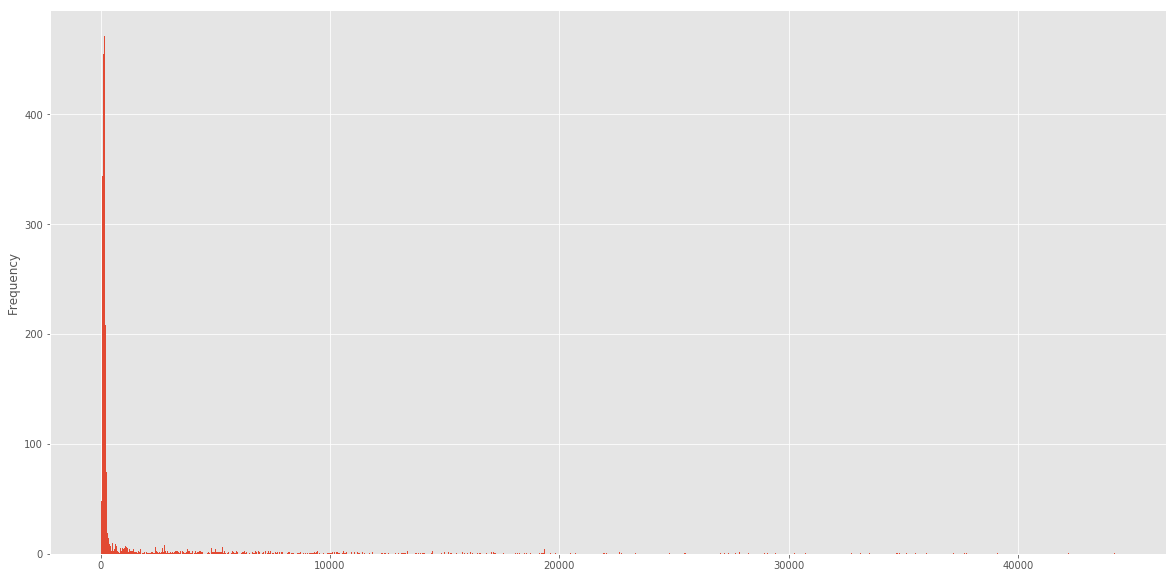

In [11]:
plt.figure(figsize=(20,10))
northbound['time_north'].astype('timedelta64[s]').plot.hist(bins=1000)

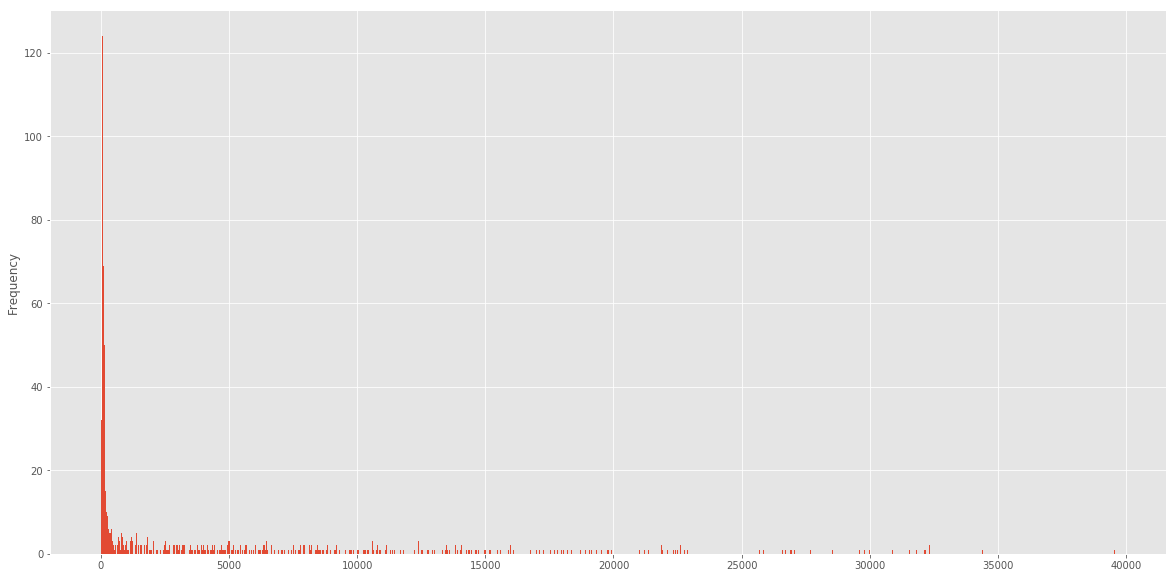

In [12]:
plt.figure(figsize=(20,10))
southbound['time_south'].astype('timedelta64[s]').plot.hist(bins=1000)

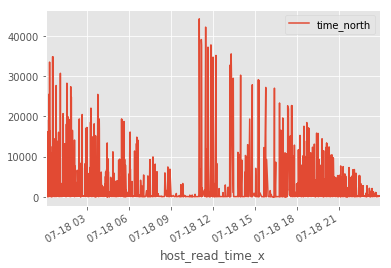

In [13]:
plt.figure(figsize=(20,10))
northbound = northbound.assign(time_north=northbound['time_north'].astype('timedelta64[s]'))
northbound.plot(x='host_read_time_x', y='time_north')

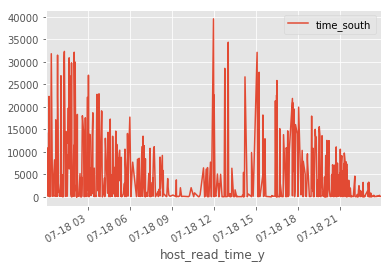

In [14]:
plt.figure(figsize=(20,10))
southbound = southbound.assign(time_south = southbound['time_south'].astype('timedelta64[s]'))
southbound.plot(x='host_read_time_y', y='time_south')

In [84]:
def date_range(start, end, intv):
    while start < end:
        yield (start, start + intv)
        start += intv
    yield (start, start + intv)
    
def density_by_time(dataframe, start_column, end_column, delta):
    dataframe = dataframe.sort_values(by=start_column)
    x_list = dataframe[start_column].tolist()
    date_buckets = []
    for d in date_range(x_list[0], x_list[-1], delta):
        date_buckets.append(d)
        
    counts = []
    for bucket in date_buckets:
        gtlb = dataframe[dataframe[start_column] >= bucket[0]]
        gtlb = gtlb[gtlb[start_column] < bucket[1]]
        ltub = gtlb[gtlb[end_column] > bucket[1]]
        counts.append(len(ltub))
        
    plt.plot([b[0] for b in date_buckets], counts)

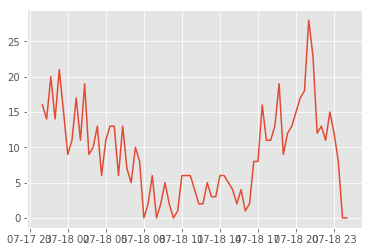

In [88]:
density_by_time(northbound, 'host_read_time_x', 'host_read_time_y', timedelta(minutes=20))

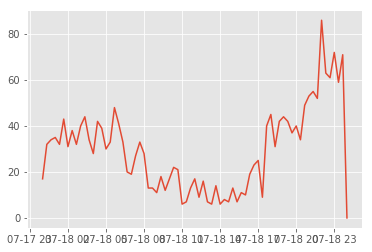

In [90]:
throughput_by_time(northbound, 'host_read_time_y', timedelta(minutes=20))

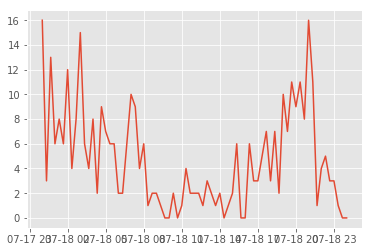

In [87]:
density_by_time(southbound, 'host_read_time_y', 'host_read_time_x', timedelta(minutes=20))

In [89]:
def throughput_by_time(dataframe, exit_column, delta):
    #make sure the dataframe is sorted
    dataframe = dataframe.sort_values(by=exit_column)
    #turn the series into a list, easier to work with
    x_list = dataframe[exit_column].tolist()
    #create the buckets in even intervals during the time frame
    date_buckets = []
    for d in date_range(x_list[0], x_list[-1], delta):
        date_buckets.append(d)
        
    #count the events we need to measure
    counts = []
    for bucket in date_buckets:
        #get events after the start of the bucket
        gtlb = dataframe[dataframe[exit_column] >= bucket[0]]
        #get events before end of bucket
        ltub = gtlb[gtlb[exit_column] < bucket[1]]
        
        counts.append(len(ltub))
        
    plt.plot([b[0] for b in date_buckets], counts)
